In [111]:
import os
import glob 
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import extract as xfn
import register as rg
import seaborn as sns
import admin_functions1 as adfn
sns.reset_orig()
#plt.style.use('dark_background')
%load_ext autoreload
%autoreload
# Define paths
#---------------------------------------------------------------------------
Fdrop = '/Users/dominicburrows/Dropbox/PhD/analysis/'
Fmac = '/Users/dominicburrows/Documents/'
F10t = '/Volumes/Dominic 10tb/'
Ffig = '/Users/dominicburrows/Dropbox/PhD/figures/'
Ftm = '/Volumes/Dominic Time Machine/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Extract suite2p data

New imaging block design:
* Partition into baseline, light, ptz sections
* bin first 30mins of baseline
* save tail recordings 

In [ ]:
# Define which fish - load first time
#---------------------------------------------------------------------------
experiment = 'PTZ-GRIN2A--'
date = '190709-GRIN2A--'
fish = 'F02-BLN-GRIN2A---2photon-6dpf-gc6s-25%-sess-01-run-01'

# Define suite2p file location and dropbox save location
#---------------------------------------------------------------------------
Fs2p = F10t + 'Data2process/Project/' + experiment + os.sep + date + os.sep + fish + os.sep + 'suite2p'
Fsave = Fdrop + 'Project/' + experiment

#Extract all active cells from suite2p plane data and save in Fsave 
#--------------------------------------------------------------------------
Fish  = xfn.fish_load(Fs2p, Fsave, fish, experiment, date)

In [47]:
# Define which fish - reload entire block
#---------------------------------------------------------------------------
experiment = 'PTZ-WILDTYPE'
fish = 'PTZ-WILDTYPE-03'

# Define suite2p file location and dropbox save location
#---------------------------------------------------------------------------
planes = F10t + 'Data2process/Project/' + experiment + os.sep + fish 
Fsave = Fdrop + 'Project/' + experiment

#Extract all active cells from suite2p plane data and save in Fsave 
#--------------------------------------------------------------------------
Fish  = xfn.fish_reload_block(planes, Fsave, fish, experiment)

Found 10 planes
Found 48562 cells
Saved trace and coordinates in PTZ-WILDTYPE


# Back up data

In [45]:
# Define which fish - load first time
#---------------------------------------------------------------------------
experiment = 'PTZ-GRIN2A--'
date = '190709-GRIN2A--'
fish = 'F02-PTZ20-GRIN2A---2photon-6dpf-gc6s-25%-sess-01-run-01'
Fs2p = F10t + 'Data2process/Project/' + experiment + os.sep + date + os.sep + fish + os.sep + 'suite2p'

# Define backup path - Ftm or F10t
#---------------------------------------------------------------------------
backup = Ftm 

#Backup regtiffs, ops and stat files - makesubdir yes only for each new fish
#---------------------------------------------------------------------------
Backup  = xfn.fish_backup(Fs2p, backup, experiment, fish, date, makesubdir = 'no')

plane0 backed up
plane1 backed up
plane2 backed up
plane3 backed up
plane4 backed up
plane5 backed up
plane6 backed up
plane7 backed up
plane8 backed up
plane9 backed up


In [85]:
# Define which fish - reload block
#---------------------------------------------------------------------------
experiment = 'PTZ-WILDTYPE'
fish = 'PTZ-WILDTYPE-03'
savename = 'PTZ-WILDTYPE-03_2photon_sess-01-6dpf_BLN_run-01'
planes = F10t + 'Data2process/Project/' + experiment + os.sep + fish 

# Define backup path - Ftm or F10t
#---------------------------------------------------------------------------
backup = F10t 

#Backup regtiffs, ops and stat files - makesubdir yes only for each new fish
#---------------------------------------------------------------------------
Backup  = xfn.fish_rebackup(fish, savename, planes, backup, experiment)

plane1 backed up
plane2 backed up
plane3 backed up
plane4 backed up
plane5 backed up
plane6 backed up
plane7 backed up
plane8 backed up
plane9 backed up


# Filter non-cells

In [86]:
# Choose path and create lists of coord and trace files
#---------------------------------------------------------------------------
experiment = 'PTZ-WILDTYPE'
os.chdir(Fdrop + 'Project/' + experiment)
coordlist = sorted(glob.glob('*BLN-PTZ05-PTZ20*allcoord.npy'))  
tracelist = sorted(glob.glob('*BLN-PTZ05-PTZ20*alltrace.npy'))
coordlist

['PTZ-WILDTYPE-03_2photon_sess-01-BLN-PTZ05-PTZ20_run-01_allcoord.npy']

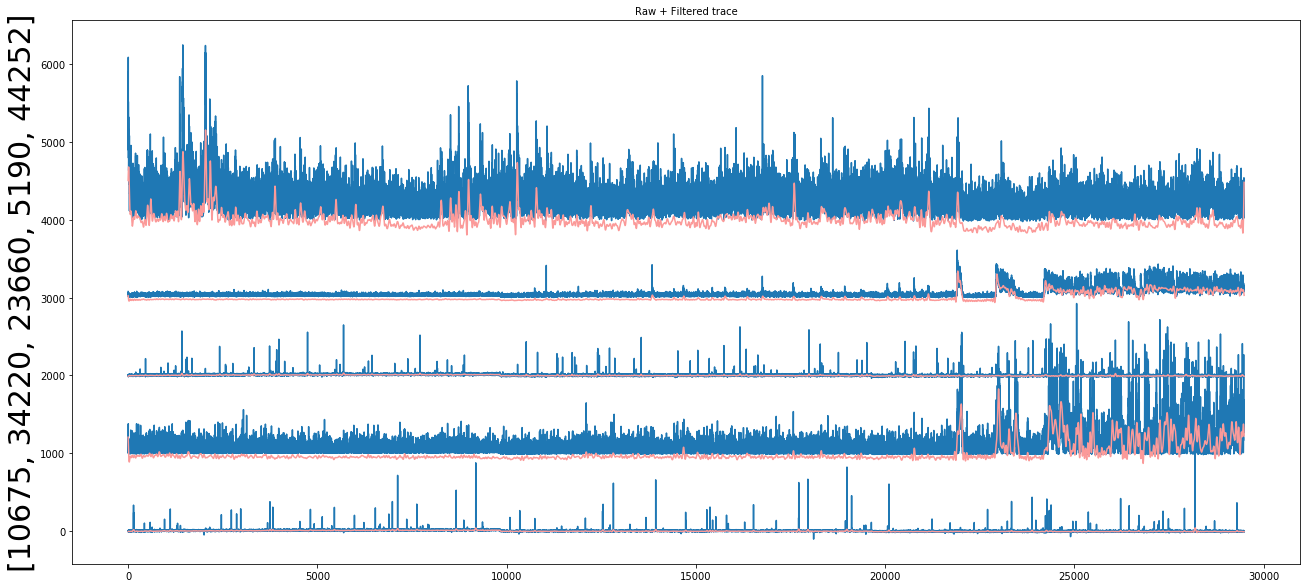

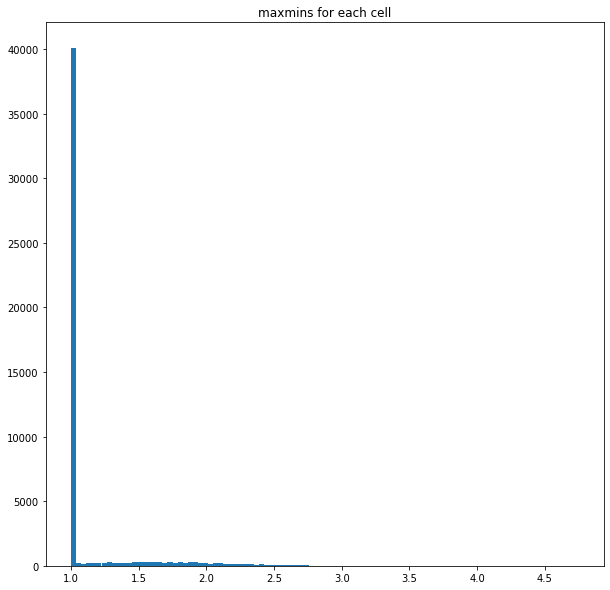

In [87]:
# Choose fish + condition - just tab in brackets to find list
#---------------------------------------------------------------------------
Fcoord = 'PTZ-WILDTYPE-03_2photon_sess-01-BLN-PTZ05-PTZ20_run-01_allcoord.npy'
Ftrace = 'PTZ-WILDTYPE-03_2photon_sess-01-BLN-PTZ05-PTZ20_run-01_alltrace.npy'
# Create dict - Fish
#---------------------------------------------------------------------------
Fish = {'Trace':np.load(Ftrace), 'Coord': np.load(Fcoord)}

# Apply bandpass filter normalise and choose n cells to plot, plot raw + filt
#-----------------------------------------------------------------------------
Ffilt, Fnorm = xfn.fish_filter(Fish['Trace'], highcut = 500, lowcut = 0, nplt = 5)
Fish.update({'Filt':Ffilt, 'Norm':Fnorm})

# Define size of sliding window in frames to calculate max of mins
#---------------------------------------------------------------------------
Fmxmn = xfn.fish_max_min(Fish['Norm'], window =9)
Fish.update({'Maxmin':Fmxmn})

Kept 8460 cells
Filtered 40102 cells


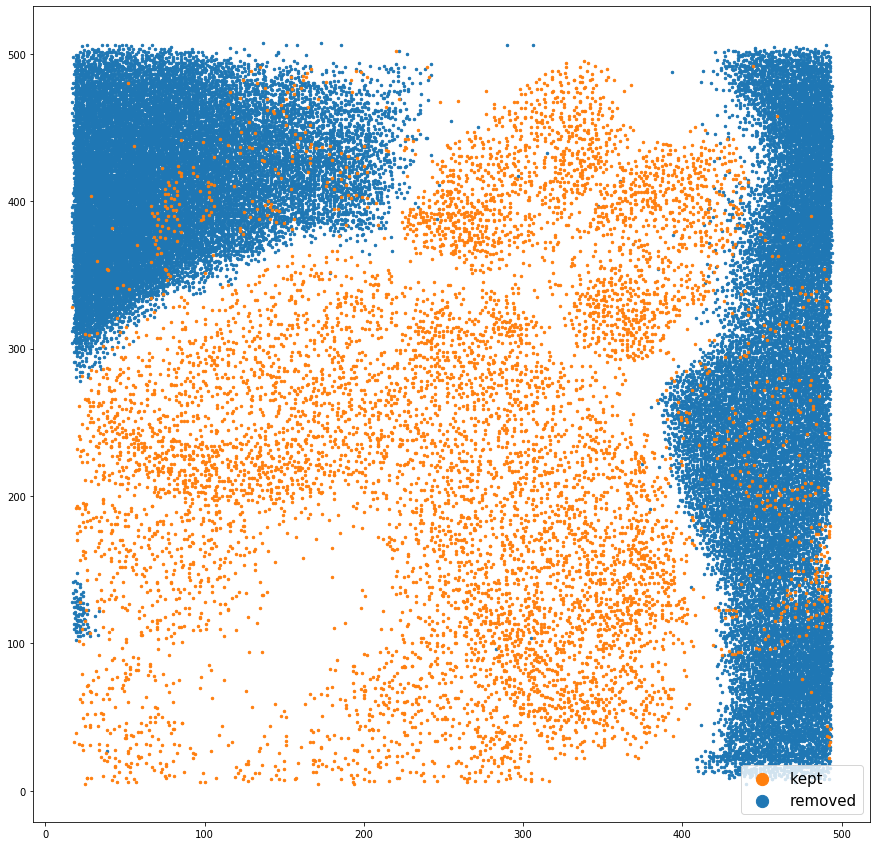

In [95]:
# Set threshold and visualise
#ELIMINATE BASED ON CELLS THAT ABSOLUTELY MUST BE NOISE - better to be more relaxed and not remove 
#true cells - any non-cells kept in should be removed by binarisation step
#---------------------------------------------------------------------------------------------------
thresh = 1.04
ffin = xfn.fish_thresh(Fish['Trace'], Fish['Coord'], Fish['Maxmin'], Ftrace, Fdrop, thresh)
Fish.update({'Realcell': ffin[1], 'Realtrace': ffin[0], 'Noisecell': ffin[3], 'Noisetrace': ffin[2]})

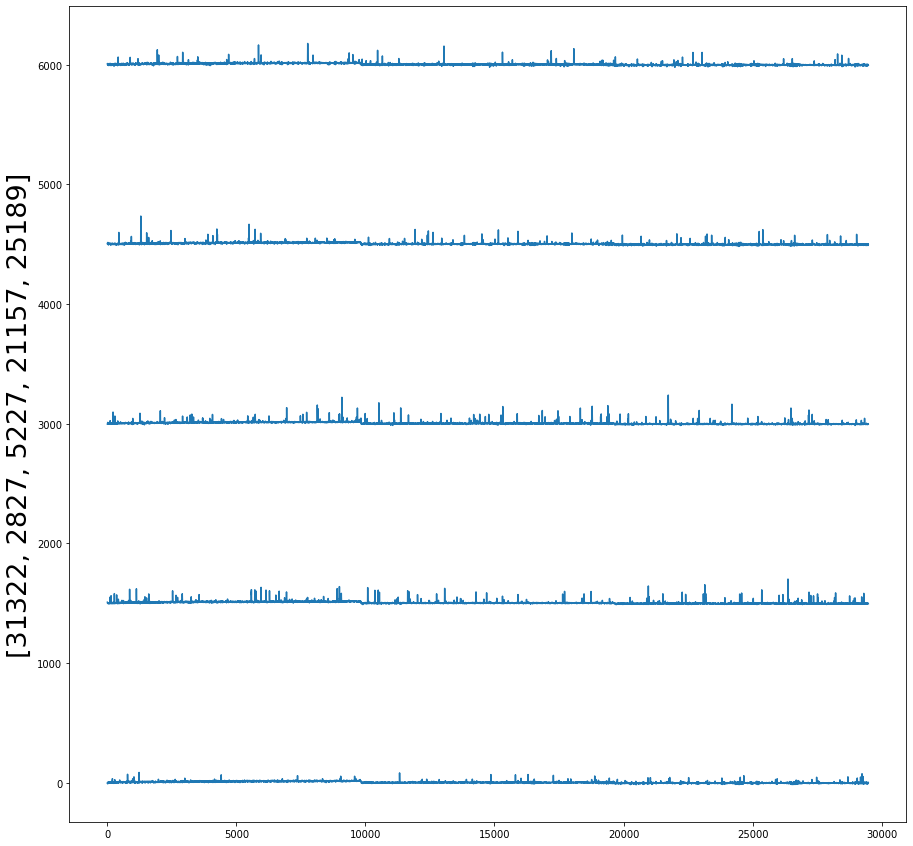

In [103]:
###### Plot raw excluded cell traces - adjust threshold
#---------------------------------------------------------------------------
import random as rand
from scipy.ndimage import gaussian_filter1d
x = Fish['Realtrace'] 
y = Fish['Noisetrace']
choose =  y

nplt  = 5
rdm = rand.sample(range(0, choose.shape [0]), nplt)
f = choose[rdm]
cm    = plt.get_cmap("Paired")
fig, ax = plt.subplots(figsize=(15,15))
ax.set_ylabel(rdm, size=27)
for i in range(nplt):
    plt.plot(gaussian_filter1d(f[i] + 1500*i, 2, axis=0), c=cm(1))

In [104]:
#Save final threshold and save as .npy file of all real cells 
#Convert trace to csv for binarisation, normalisation and ensemble calculation
#---------------------------------------------------------------------------------------------------
fr = xfn.fish_save(experiment, Fcoord, Fish['Trace'], Fish['Coord'], Fish['Maxmin'], Ftrace, Fdrop, thresh)

# Binarise traces

In [110]:
# Choose path and create lists of coord and trace files
#---------------------------------------------------------------------------
experiment = 'PTZ-WILDTYPE'
os.chdir(Fdrop + 'Project/' + experiment)
realtracelist = sorted(glob.glob('*BLN-PTZ05-PTZ20*realtrace.npy')) 
realtracelist

['PTZ-WILDTYPE-03_2photon_sess-01-BLN-PTZ05-PTZ20_run-01_realtrace.npy']

In [57]:
wdtlist = [0.47, 0.49, 0.51, 0.53, 0.55, 0.57,0.59, 0.61, 0.63, 0.65]

In [61]:
wdt = 0.57 #spiking probability = 0.57
lamb = 0.5 #calcium decay = 0.5
varB = 0.001 #baseline variance = 0.001
varC = 1 #calcium variance = 1
Cmean = 0.2 #mean calcium = 0.2
frequency = 2.7 #frequency = 2.7
gausfilt = 0.6 #gausfilt = 0.6
mode = 'see'
name = realtracelist[0]

c, sks, B = xfn.bcl_function_parameters(wdt, Fdrop, experiment, name, lamb, varB, varC, Cmean, frequency, gausfilt, mode )


In [ ]:
        np.save(savepath + 'Project/' + experiment + os.sep + name[:name.find('run')+6] + '_' + str(wdt) + 'deltaff.npy', dffarray)  

# RIP ----- Code Graveyard

In [ ]:
#boxplot 
#-----------

slopesize = pd.DataFrame({'Baseline': blns, 'PTZ 5mM': p5s, 'PTZ 20mM': p20s})
slopesize

import seaborn as sns
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize = (12,12))

ax.set_yticklabels(['1.0', '0.5','0.6', '0.7', '0.8', '0.9', '1.0'], fontsize = 20)

#plt.figure(figsize = (12,12))
ax = sns.stripplot(data=slopesize, jitter=True, color="0", size = 10)
ax = sns.pointplot(data=slopesize, linestyles = ['--'], color="#bb3f3f", size = 10, capsize = .15)
plt.ylabel("Normalised slope change", size = 30, color = 'black')
plt.xticks(np.arange(3), ('Baseline','PTZ 5mM', 'PTZ 20mM'), size = 25, color = 'black')
plt.yticks(color = 'black')
#os.chdir(Ffig)
#plt.savefig('neggausstesttruepos.png')


os.chdir(Ffig)
plt.savefig('slopechange1.png')


plt.show()


In [ ]:
#make bar plot
#-----------------------

name = ['SCN1A', 'KCNQ2', 'CDKL5', 'SCN2A', 'PCDH19', 'STXBP1', 'PRRT2', 'SLC2A1', 'MECP2', 'UBE3A', 'TSC2', 'GABRG2', 'GRIN2A']
number = [310, 155, 95, 90, 70, 60, 58, 47, 45, 25, 23, 22, 18]

genes = {'name': name, 'number': number}
genedf = pd.DataFrame.from_dict(genes)


f, ax = plt.subplots(figsize=(12, 12))
plt.bar(genedf['name'], genedf['number'], color = 'firebrick' )
ax.set_ylabel('Number of pathogenic variants', fontsize = 20)

ax.yaxis.set_tick_params(labelsize = 15)
ax.xaxis.set_tick_params(labelsize=12)

os.chdir(Ffig)
plt.savefig('genesbarchart.png')

In [ ]:
#plotting regime
#-------------------------

#PLOT TRACE AND BINARISED LINES BELOW AND DOTS ON PEAKS
#------------------------------------------------------
ch = 6
plt.figure(figsize = (44,12))
plt.plot(Fdf[ch][1000:3000], c = 'k', linewidth = 2)

for x in np.where(Fbin[ch][1000:3000] == 1)[0]: plt.scatter(x,Fdf[ch][1000:3000][x] , marker = '.', s=200, c='red', alpha = 1)
for x in np.where(Fbin[ch][1000:3000] == 1)[0]: plt.vlines(x=x,  alpha = 1, ymin = -5, ymax = -2, color = 'red')

#PLOT BOX AND WHISKER PLOT
#-----------------------------
truepos = pd.DataFrame({'Phasic true pos': np.append(np.append(np.append(a,b),c),d), 'Tonic true pos': np.append(np.append(np.append(e,f),g),h)})
falsepos = pd.DataFrame({'Phasic false pos': np.append(np.append(np.append(a1,b1),c1),d1), 'Tonic false pos': np.append(np.append(np.append(e1,f1),g1),h1)})

import seaborn as sns
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize = (12,12))

ax.set_yticklabels(['40', '40','50', '60', '70', '80'], fontsize = 15)

#plt.figure(figsize = (12,12))
ax = sns.stripplot(data=truepos, jitter=True, color="0", size = 10)
ax = sns.pointplot(data=truepos, linestyles = ['--'], color="#bb3f3f", size = 10, capsize = .15)
plt.ylabel("True positive detections (%)", size = 30, color = 'black')
plt.xticks(np.arange(3), ('Phasic cells','Tonic cells'), size = 25, color = 'black')
plt.yticks(color = 'black')
os.chdir(Ffig)
plt.savefig('neggausstesttruepos.png')
plt.show()


#PLOT TRACE AND BINARISED FIRING EVENTS
#-------------------------------------
ch = 3
plt.figure(figsize = (22,6))
plt.plot(trace2smooth[ch][:1000], c = 'k', linewidth = 0.5)

for x in np.where(Fbin[ch][:1000] == 1)[0]: plt.axvline(x=x, marker = '.', alpha = 0.5, ymin = 0, ymax = 60)

plt.show()



#PLOT SMOOTHED BASELINE AND TRACE
#-----------------------------------------
alpha = ['0','36', '72', '108', '144', '180']
beta = ['0', '200', '400', '600', '800', '1000', '1200']

fig, ax = plt.subplots(figsize = (10,10))

# title and labels, setting initial sizes
ax.set_xlabel('Time (s)')
ax.set_ylabel('Raw fluorescence [au]')   # relative to plt.rcParams['font.size']

ax.set_xticklabels(['']+alpha, fontsize = 15)
ax.set_yticklabels(['']+beta, fontsize = 15)

ax.plot(trace2smooth[5517][1000:1500], c = 'k', linewidth = 0.5)
ax.plot(Fsmooth[0][1000:1500], c = 'r', linewidth = 2)

# setting label sizes after creation
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.draw()
os.chdir(Ffig)
plt.savefig('baselinezoomtrace.png')



In [ ]:
#Calculate slowly varying baseline (Fsmooth) and deltaf/f
#define parameters (percentile - 0.08, windowscale = 2)
#--------------------------------------------------------
Fsmooth, Fdf, Fbin = xfn.fish_fsmooth(Fdrop, experiment, fish, trace2smooth, framerate = 2.73, percentile = 0.08, windowscale = 2, select = 'all', nplt = 5, nstd = 2)
#Fish.update({'Maxmin':Fmxmn})


#========================================================================
def fish_fsmooth(Fdrop, experiment, fish, trace2smooth, framerate, percentile, windowscale, select, nplt, nstd):   # Calculate Fsmooth
#========================================================================
    import random as rand
    from scipy.stats import norm
    import matplotlib.mlab as mlab

    
#calculate slowly varying baseline Fsmooth and delta F/f
#Fsmooth takes the nth lowest percentile of window size around the time point to calculate Fsmooth
#sumbre lab - define window size as 40x decay of probe - decay of gc6s is 1s
#-------------------------------------------------------------------------------------------------
    Fsmoothmx = np.zeros(trace2smooth.shape)
    Fdf = np.zeros(trace2smooth.shape)
    Fbin = np.zeros(trace2smooth.shape)
    window = (int((trace2smooth.shape[0] / (trace2smooth.shape[0]/framerate)) * 40) - 1)* windowscale  
    count = 0
    
    if select == 'vis':
        rdm = rand.sample(range(0, trace2smooth.shape [0]), 5)
        for y in rdm:
            Fsmooth = np.zeros((trace2smooth.shape[1]))
            newwindow = 0
            for i in range(trace2smooth.shape[1]):
                if i == 0:
                    Fsmooth[i] = (trace2smooth[y,i] + np.mean(trace2smooth[y,:]))/2
                elif i == 1:
                    Fsmooth[i] = (trace2smooth[y,i] + np.mean(trace2smooth[y,:]))/2
                elif i < window:
                    newwindow = len(range(i))
                    Fsmooth[i] = (np.mean(trace2smooth[y,:]) + np.mean(trace2smooth[y,:][int(i-(newwindow/2)):int((i+newwindow/2))][np.where(trace2smooth[y,:][int(i-(newwindow/2)):int((i+newwindow/2))] < np.quantile(trace2smooth[y,:][int(i-(newwindow/2)):int((i+newwindow/2))], percentile, axis = 0)) [0]]))/2

                else:
                    Fsmooth[i] = (np.mean(trace2smooth[y,:]) + np.mean(trace2smooth[y,:][int(i-(window/2)):int((i+window/2))][np.where(trace2smooth[y,:][int(i-(window/2)):int((i+window/2))] < np.quantile(trace2smooth[y,:][int(i-(window/2)):int((i+window/2))], percentile, axis = 0)) [0]]))/2
        
            Fsmoothmx[count,:] = Fsmooth
            Fdf[count,:] = (trace2smooth[y,:] - Fsmooth)/Fsmooth
            count +=1
            
        fig, ax = plt.subplots(figsize=(22,16))
        ax.set_ylabel(rdm, size=30)
        pltcount = 0
        for t in range(nplt):
            plt.plot(trace2smooth[rdm[t]] + 2500*pltcount, c='k', linewidth = 0.5)
            plt.plot(Fsmoothmx[t,:] + 2500*pltcount, c='r')
            pltcount += 1
            
        return(Fsmoothmx, Fdf)
    

    
    elif select == 'all':
        printcount = 0
        for y in range(10):
            Fsmooth = np.zeros((trace2smooth.shape[1]))
            newwindow = 0
            print('doing cell ' + str(y) + ' of ' + str(trace2smooth.shape[0]))
            

            #tlen = trace2smooth.shape[0]
            
            #if printcount % round(10*tlen/100) == 0: print("Doing cell " + str(printcount) + " of " + str(tlen)) 
            #printcount += 1
                                        
                                        
            for i in range(trace2smooth.shape[1]):
                if i == 0:
                    Fsmooth[i] = (trace2smooth[y,i] + np.mean(trace2smooth[y,:]))/2
                elif i == 1:
                    Fsmooth[i] = (trace2smooth[y,i] + np.mean(trace2smooth[y,:]))/2
                elif i < window:
                    newwindow = len(range(i))
                    Fsmooth[i] = (np.mean(trace2smooth[y,:]) + np.mean(trace2smooth[y,:][int(i-(newwindow/2)):int((i+newwindow/2))][np.where(trace2smooth[y,:][int(i-(newwindow/2)):int((i+newwindow/2))] < np.quantile(trace2smooth[y,:][int(i-(newwindow/2)):int((i+newwindow/2))], percentile, axis = 0)) [0]]))/2

                else:
                    Fsmooth[i] = (np.mean(trace2smooth[y,:]) + np.mean(trace2smooth[y,:][int(i-(window/2)):int((i+window/2))][np.where(trace2smooth[y,:][int(i-(window/2)):int((i+window/2))] < np.quantile(trace2smooth[y,:][int(i-(window/2)):int((i+window/2))], percentile, axis = 0)) [0]]))/2
        
            Fsmoothmx[y,:] = Fsmooth
            Fdf[y,:] = (trace2smooth[y,:] - Fsmooth)/Fsmooth
            
            

        
       
        #Fit Gaussian to all the negative fluctuations below baseline
        #------------------------------------------------------------

        #Generate symmetrical data about 0
        #-------------------------------------
            neg = Fdf[y,:][Fdf[y,:]<0]
            pos = neg * -1
            symmval = np.append(neg,pos)

        #Fit normal distribution to symmval
        #------------------------------------
            mu, std = norm.fit(symmval)

        #plot hist of all data, and fit and define threshold
        #------------------------------------------------------------
            plt.figure(figsize=(20,15))
            plt.hist(Fdf[y,:], normed = 1, bins=200, range=(min(Fdf[y,:]),max(Fdf[y,:])), rwidth = 10)
            xmin, xmax = plt.xlim()
            x = np.linspace(xmin, xmax, 100)
            p = norm.pdf(x, mu, nstd*std)
            thresh = x[np.where(p < 0.001) [0][0]]
            Fbin[y,:][np.where(Fdf[y,:]>thresh)[0]] = 1
        

        #np.save(Fdrop + os.sep + experiment + os.sep + fish + os.sep + fish + '_' + 'prac_smooth.npy', Fsmoothmx)
        #np.save(Fdrop + os.sep + experiment + os.sep + fish + os.sep + fish + '_' + 'prac_fdf.npy', Fdf)
        #np.save(Fdrop + os.sep + experiment + os.sep + fish + os.sep + fish + '_' + 'prac_bin.npy', Fbin)
        return(Fsmoothmx, Fdf, Fbin)
    



In [ ]:
#binarise by taking 3std from mean
#------------------------------------

#========================================================================
def fish_bin(realtrace, realcell, Ftrace, Fdrop, stdlim, cnt, typ, cell, save):  
#========================================================================

    import numpy as np
    from scipy import stats
    from scipy import signal
    import matplotlib.pyplot as plt
    import os


    pks = np.zeros(realtrace.shape)
    # Find activity peaks
    #---------------------------------------------------------------------------

    for i in range(realtrace.shape[0]):
        d = realtrace[i,:]   
        
        if typ == 'peaks':
            p, prop = signal.find_peaks(d,threshold=np.percentile(d,cnt))
        
        elif typ == 'std':
            sem = np.std(d)
            p   = np.where(d > stdlim*sem)[0]
        
        else: print('Don''t know what type of binarisation to use')
        
        pks[i,p] = 1
    
    plt.figure(figsize = (15,3))
    for x in np.where(pks[cell,:])[0]: plt.axvline(x=x, c='gray')
    plt.plot(realtrace[cell,:])
    
    
    if save == 'yes':
        # Save real cell coords and traces in new folder and save each plane as well
        #--------------------------------------------------------------------------------
        os.chdir(Fdrop)    
        p_id = 'flt_' + Ftrace[56:73]
        os.chdir(p_id)
        np.save(p_id[4:] + '_all_' + 'bin.npy', pks)

        # Create two variables for number of cells in each plane from filtered file, from this
        # save in new files
        #--------------------------------------------------------------------------------
        planes, counts = np.unique(realcell[:,2], return_counts=True)
        counter = 0
        for i in range(len(planes)):
            np.save('plane_' + str(i) + '_bin.npy', pks[counter:counter + counts[i],:])
            counter = counter + counts[i]

    return(pks)

In [ ]:
#attempts to normalise
#--------------------------

inp = '190307_wt_F1_bln'
rfile = Fdrop + '/flt_' + inp + '/' + 'flt_' + inp + '_com_signal.npy'
b4norm = np.load(rfile)
c = 8


window = 24
norm = np.zeros(b4norm[c,:].shape[0])


for i in range((b4norm[c,:].shape)[0]):
    back = i - window
    front = i+ window
    timepoint = b4norm[c,i]

    if back < 0: back = 0
    if front > b4norm[c,:].shape[0] - 1: front = b4norm[c,:].shape[0] - 1
    
    sumvals = 0
    for t in range(back, front + 1):
        vals = b4norm[c,t]
        sumvals = sumvals + vals
        binsize = front - back
    
    norm[i] = timepoint - (sumvals/(front-back))

f, axarr = plt.subplots(1,2, sharey=True, sharex=True, figsize = (20,8))
axarr[0].plot(b4norm[c])
axarr[1].plot(norm)
plt.show()